### Working with Outliers

An outlier is a data point that diverges notably from other values within a variable. Outliers may stem from the inherent variability of the feature itself, manifesting as extreme values that occur infrequently within the distribution (typically found in the tails). They can be the result of experimental errors or inaccuracies in data collection processes, or they can signal important events. For instance, an unusually high expense in a card transaction may indicate fraudulent activity, warranting flagging and potentially blocking the card to safeguard customers. Similarly, unusually distinct tumor morphologies can suggest malignancy, prompting further examination.

- Visualizing outliers with boxplots and the inter-quartile proximity rule
- Finding outliers using the mean and standard deviation
- Using the median absolute deviation to find outliers
- Removing outliers
- Bringing outliers back within acceptable limits
- Applying winsorization

### Visualizing outliers with boxplots and the inter-quartile proximity rule

A common way to visualize outliers is by using boxplots. Boxplots provide a standardized display of the variable's distribution based on quartiles. The box contains the observations within the first and third quartiles, known as the Inter-Quartile Range (IQR). The first quartile is the value below which 25% of the observations lie (equivalent to the 25th percentile), while the third quartile is the value below which 75% of the observations lie (equivalent to the 75th percentile). The IQR is calculated as follows:

![Outliers in boxplot len](../img/outliers.png)

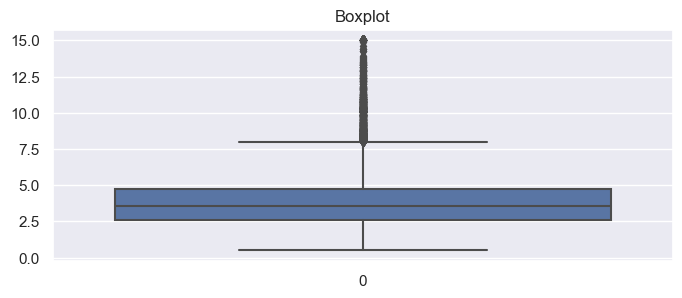

In [11]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing


warnings.filterwarnings('ignore')

sns.set(style='darkgrid')

X,y = fetch_california_housing(return_X_y=True, as_frame=True)

plt.figure(figsize=(8, 3))
sns.boxplot(data=X["MedInc"], orient="y")
plt.title("Boxplot")
plt.show()

In [12]:
# Let's create a function to plot a boxplot next to a histogram
def plot_boxplot_and_hist(data, variable):
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True,
        gridspec_kw={"height_ratios": (0.50, 0.85)})
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)
    plt.show()

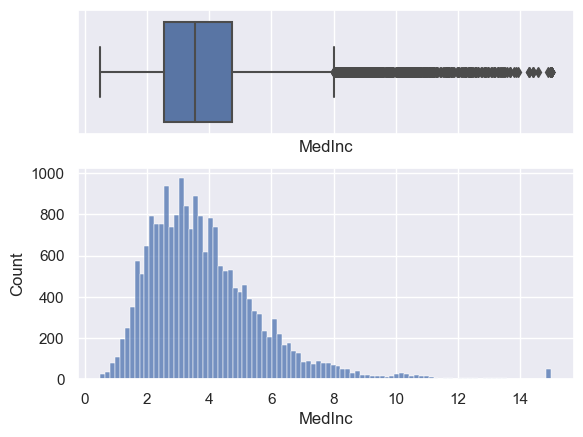

In [13]:
plot_boxplot_and_hist(X, 'MedInc')

In the following figure, we can see the relationship between the boxplot and the variable's distribution shown in the histogram. Note how most of MedInc's observations are located within the IQR box. MedInc's potential outliers lie on the right tail, corresponding to people with unusually high-income salaries:

**IMPORTANT**: Now that we've seen how we can visualize outliers, let's see how to calculate the limits beyond which we find outliers at each side of the distribution.

In [15]:
# Let's create a function that returns the limits based on the IQR proximity rule:

def find_limits(df, variable, fold):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    IQR = q3 - q1
    lower_limit = q1 - (IQR * fold)
    upper_limt = q3 + (IQR * fold)
    return lower_limit, upper_limt

In [16]:
lower_limit, upper_limit = find_limits(X, "MedInc", 1.5)

If we now execute lower_limit and upper_limit, we will see the values -0.7063 and 8.013. The lower limit is beyond MedInc's minimum value, hence in the boxplot, the whisker only goes up to the minimum value. The upper limit, on the other hand, coincides with the right whisker's limit.

In [18]:
print(lower_limit)
print(upper_limit)

-0.7063750000000004
8.013024999999999


Let's display the box plot and histogram for the HouseAge variable:

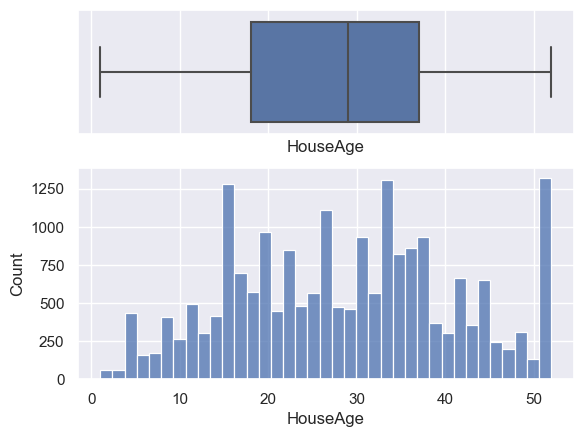

In [19]:
plot_boxplot_and_hist(X, "HouseAge")

Let's find the variable's limits according to the IQR proximity rule:

In [21]:
lower_limit, upper_limit = find_limits(X, 'HouseAge', 1.5)

print(lower_limit)
print(upper_limit)

-10.5
65.5


### Finding outliers using the mean and standard deviation

In normally distributed variables, around 99.8% of the observations lie within the interval comprising the mean plus and minus three times the standard deviation. Thus, values beyond those limits can be considered outliers; they are rare.

**NOTE**: Using the mean and standard deviation to detect outliers has some drawbacks. Firstly, it assumes a normal distribution, including outliers. Secondly, outliers strongly influence the mean and standard deviation. Therefore, a recommended alternative is the Median Absolute Deviation (MAD), which we'll discuss in the next recipe

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True, as_frame=True)

def plot_boxplot_and_hist(data, variable):
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True,
        gridspec_kw={"height_ratios": (0.50, 0.85)})
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)
    plt.show()

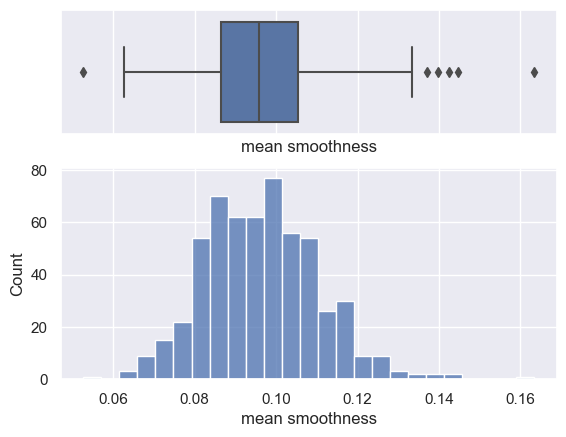

In [26]:
plot_boxplot_and_hist(X, "mean smoothness")

In the following boxplot, we see that the variable's values show a distribution like the normal distribution, and it has six outliers one on the left and five on the right tail:

Create a function that returns the mean plus and minus fold times the standard deviation, where fold is a parameter to the function

In [28]:
def find_limits(df, variable, fold):
    var_mean = df[variable].mean()
    var_std = df[variable].std()
    lower_limit = var_mean - fold * var_std
    upper_limit = var_mean + fold * var_std
    return lower_limit, upper_limit

lower_limit, upper_limit = find_limits(X, 'mean smoothness', 3)

print(lower_limit)
print(upper_limit)

0.05416789678205824
0.13855266560809995


Create a Boolean vector that flags observations with values beyond the limits

In [32]:
outliers = np.where(
    (X['mean smoothness'] > upper_limit) |
    (X['mean smoothness'] < lower_limit),
    True, 
    False 
)
outliers.sum()

5

If we now execute outliers.sum(), we will see the value 5, indicating that there are five outliers or observations that are smaller or greater than the extreme values found with the mean and the standard deviation. According to these limits, we'd identify one outlier less compared to the IQR rule.

Let's add red vertical lines to the histogram from step 3 to highlight the limits determined by using the mean and the standard deviation

In [33]:
def plot_boxplot_and_hist(data, variable):
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True,
        gridspec_kw={"height_ratios": (0.50, 0.85)}
    )
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)
    plt.vlines(
        x=lower_limit, ymin=0, ymax=80, color='r'
    )
    plt.vlines(x=upper_limit, ymin=0, ymax=80, color='r')
    plt.show()

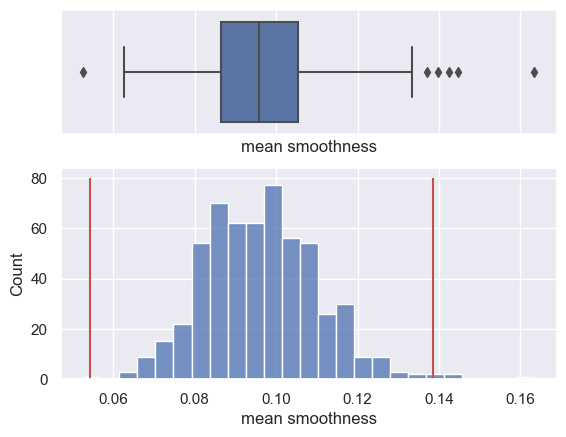

In [35]:
plot_boxplot_and_hist(X, 'mean smoothness')

### Using the median absolute deviation to find


The mean and the standard deviation are heavily impacted by outliers. Hence, using these parameters to identify outliers can defeat the purpose. A better way to identify outliers is by using MAD. MAD is the median of the absolute deviation between each observation and the median value of the variable:

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True, as_frame=True)


# create a function that returns the limits based on MAD
def find_limits(df, variable, fold):
    median = df[variable].median()
    center = df[variable] - median
    MAD = center.abs().median() * 1.4826
    lower_limit = median - fold * MAD
    upper_limit = median + fold * MAD
    return lower_limit, upper_limit

In [37]:
lower_limit, upper_limit = find_limits(X, 'mean smoothness', 3)

print(lower_limit)
print(upper_limit)

0.05361590000000002
0.13812409999999997


In [38]:
outliers = np.where(
    (X['mean smoothness'] > upper_limit) |
    (X['mean smoothness'] < lower_limit),
    True,
    False
)

outliers.sum()

5

If we now execute outliers.sum(), we will see the value 5, indicating that there are five outliers or observations that are smaller or greater than the extreme values found with MAD.

Let's make a function to plot a boxplot next to a histogram of a variable, highlighting in the histogram the limits calculated

In [39]:
def plot_boxplot_and_hist(data, variable):
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True,
        gridspec_kw={"height_ratios": (0.50, 0.85)}
    )
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)
    plt.vlines(x=lower_limit, ymin=0, ymax=80, color='r')
    plt.vlines(x=upper_limit, ymin=0, ymax=80, color='r')
    plt.show()


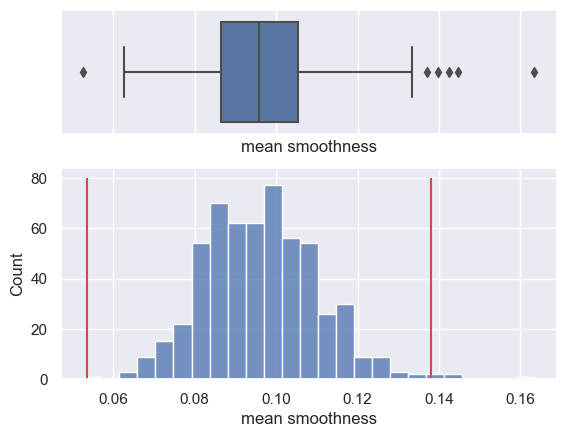

In [40]:
plot_boxplot_and_hist(X, 'mean smoothness')

**NOTE**: Detecting outliers with MAD requires that the variable has certain variability. If more than 50% of the values in a variable are identical, the median coincides with the most frequent value, and MAD=0. This means that all values different from the median will be flagged as outliers. This constitutes another limitation of using MAD in outlier detection.

### Removing outliers

Recent studies distinguish three types of outliers: error outliers, interesting outliers, and random outliers. Error outliers are likely due to human or methodological errors and should be either corrected or removed from the data analysis. In this recipe, we'll assume outliers are errors (you don't want to remove interesting or random outliers) and remove them from the dataset


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from feature_engine.outliers import OutlierTrimmer

X,y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)


Let's create a function to find the limits beyond which we'll consider a data point an outlier using the IQR proximity rule

In [42]:
def find_limits(df, variable, fold):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    IQR = q3 - q1
    lower_limit = q1 - (IQR * fold)
    upper_limit = q3 + (IQR * fold)
    return lower_limit, upper_limit

**NOTE**: In step 3, we use the IQR proximity rule to find the limits beyond which data points will be considered outliers, which we discussed in the Visualizing outliers with boxplots and the inter-quartile proximity rule recipe. Alternatively, you can identify outliers with the mean and the standard deviation or MAD, as we covered in the Finding outliers using the mean and standard deviation and Using the median absolute deviation to find outliers recipes.

In [45]:
# Using the function from step 3 , let's determine the limits of the MedInc variable:
lower, upper = find_limits(X_train, "MedInc", 3)

print(lower, upper)


-3.925900000000002 11.232600000000001


In [50]:
inliers = X_train['MedInc'].ge(lower)
train_t = X_train.loc[inliers]
inliers = X_test['MedInc'].ge(lower)
test_t = X_test.loc[inliers]

Let's retain the observations whose values are lower than or equal to (le) the upper limit:

In [51]:
inliers = X_train['MedInc'].le(upper)
train_t = X_train.loc[inliers]
inliers = X_test['MedInc'].le(upper)
test_t = X_test.loc[inliers]

In [52]:
X_train.shape, train_t.shape

((14448, 8), (14348, 8))

transformed DataFrame contains fewer observations than the original one after removing the outliers.

### We can remove outliers across multiple variables simultaneously with feature-engine.

In [54]:
trimmer = OutlierTrimmer(
    variables=['MedInc','HouseAge','Population'],
    capping_method='iqr',
    tail='both',
    fold=1.5
)

**NOTE**: OutlierTrimmer can identify boundaries using the IQR, as we show in this recipe, as well as by using the mean and standard deviation, or MAD. You need to change capping_method to gaussian or mad, respectively.

In [55]:
trimmer.fit(X_train)

OutlierTrimmer(capping_method='iqr', fold=1.5, tail='both',
               variables=['MedInc', 'HouseAge', 'Population'])

In [56]:
trimmer.left_tail_caps_

{'MedInc': -0.6776500000000012, 'HouseAge': -10.5, 'Population': -626.0}

In [57]:
trimmer.right_tail_caps_

{'MedInc': 7.984350000000001, 'HouseAge': 65.5, 'Population': 3134.0}

In [58]:
train_t = trimmer.transform(X_train)
test_t = trimmer.transform(X_test)

In [62]:
X_train.shape, train_t.shape

((14448, 8), (13165, 8))

In [59]:
def plot_boxplot_and_hist(data, variable):
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True,
        gridspec_kw={"height_ratios": (0.50, 0.85)}
    )
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)
    plt.show()

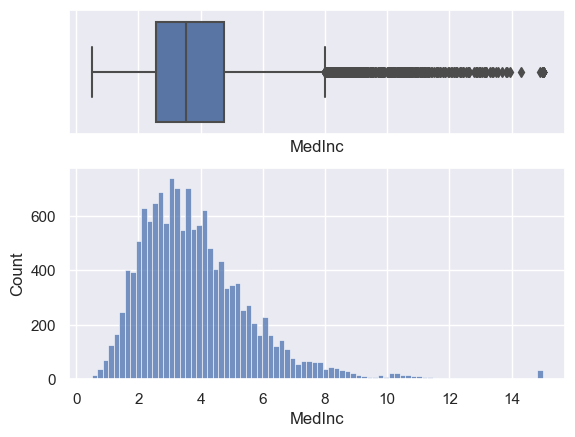

In [60]:
plot_boxplot_and_hist(X_train, 'MedInc')

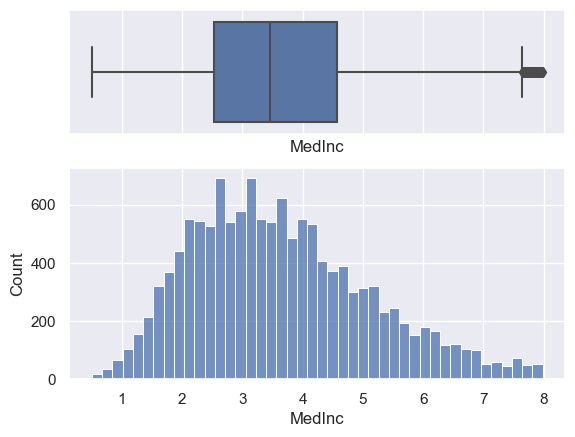

In [61]:
plot_boxplot_and_hist(train_t, 'MedInc')

**NOTE**: Using the IQR rule over the transformed variable reveals new outliers. This is not surprising; removing observations at the extremes of the distribution alters parameters such as the median and quartile values, which in turn determine the length of the whiskers, potentially identifying additional observations as outliers. The tools that we use to identify outliers are just that: tools. To unequivocally identify outliers, we need to support these tools with additional data analysis

### Bringing outliers back within acceptable limits


Removing error outliers can be a valid strategy. However, this approach can reduce statistical power, in particular when there are outliers across many variables, because we end up removing big parts of the dataset. An alternative way to handle error outliers is by bringing outliers back within acceptable limits. In practice, what this means is replacing the value of the outliers with some thresholds identified with the IQR proximity rule, the mean and standard deviation, or MAD. In this recipe, we'll replace outlier values using pandas and feature-engine.

In [63]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

def find_limits(df, variable, fold):
    var_mean = df[variable].mean()
    var_std = df[variable].std()
    lower_limit = var_mean - fold * var_std
    upper_limit = var_mean + fold * var_std
    return lower_limit, upper_limit


**NOTE**: In step 3, we use the mean and standard deviation to find the limits beyond which data points will be considered outliers, as discussed in the Finding outliers using the mean and standard deviation recipe. Alternatively, you can identify outliers with the IQR rule or MAD, as we covered in the Visualizing outliers with boxplots and the inter-quartile proximity rule and Using the median absolute deviation to find outliers recipes

Using the function from step 3, let's determine the limits of the mean smoothness variable, which follows approximately a Gaussian distribution:

In [64]:
var = "worst smoothness"
lower_limit, upper_limit = find_limits(X_train, var, 3)

print(lower_limit)
print(upper_limit)

0.06356074164705164
0.20149734880520967


In [65]:
train_t = X_train.copy()
test_t = X_test.copy()

In [66]:
# Now, replace outliers with the lower or upper limits from step 4 in the new DataFrames
train_t[var] = train_t[var].clip(lower=lower_limit, upper=upper_limit)
test_t[var] = test_t[var].clip(lower=lower_limit, upper=upper_limit)

In [67]:
train_t[var].agg(['min','max'])

min    0.071170
max    0.201497
Name: worst smoothness, dtype: float64

### We can replace outliers in multiple variables simultaneously by utilizing feature-engine

In [70]:
capper = Winsorizer(
    variables=['worst smoothness','worst texture'],
    capping_method='gaussian',
    tail='both',
    fold=3
)

**NOTE**:Winsorizer can identify boundaries using the mean and standard deviation, as we show in this recipe, as well as the IQR proximity rule and MAD. You need to change capping_method to iqr or mad, respectively.

In [71]:
capper.fit(X_train)

Winsorizer(fold=3, tail='both', variables=['worst smoothness', 'worst texture'])

In [72]:
capper.left_tail_caps_

{'worst smoothness': 0.06364743973736293, 'worst texture': 7.115307053129349}

In [73]:
capper.right_tail_caps_

{'worst smoothness': 0.2014106507148984, 'worst texture': 43.95373817300131}

In [74]:
train_t = capper.transform(X_train)
test_t = capper.transform(X_test)

In [76]:
train_t[capper.variables_].agg(['min','max'])

,worst smoothness,worst texture
min,0.071170,12.020000
max,0.201411,43.953738


### Applying winsorization

Winsorizing, or winsorization, consists of replacing extreme, poorly known observations, that is, outliers, with the magnitude of the next largest (or smallest) observation. It's similar to the procedure described in the previous recipe, Bringing outliers back within acceptable limits, but not exactly the same.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# Capture the 5th and 95th percentiles of each variable in dictionaries:
q05 = X_train.quantile(0.5).to_dict()
q95 = X_train.quantile(0.95).to_dict()

Let's now replace values beyond those percentiles with the respective percentiles for all variables at once:

In [81]:
train_t = X_train.clip(lower=q05, upper=q95)
test_t = X_train.clip(lower=q05, upper=q95)

In [82]:
var = 'worst smoothness'
X_train[var].agg(['min','max','mean'])

min     0.071170
max     0.222600
mean    0.132529
Name: worst smoothness, dtype: float64